In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import griddata

from funcs.tse import get_ticker_name_list

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [4]:
def plot_contourmap(ax, Xi, Yi, Zi):
    # z>0 の等高線（暖色）
    levels_pos = np.linspace(0, np.nanmax(Zi), 8)
    cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)
    # z<0 の等高線（寒色）
    levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
    cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)
    # z=0 の等高線（黒）
    cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)

    # ラベル
    ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
    ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
    ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

In [5]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

In [6]:
def conv_df2html(df: pd.DataFrame):
    # HTML 形式で出力
    styled = df.style.format({"取引回数": "{:d}", "損益": "{:.1f}"}).set_table_styles(
        [
            {"selector": "td", "props": "text-align: right;"},
        ]
    )
    html = styled.to_html()
    return html

In [7]:
name_doe = "doe-9a"  # 実験計画名（フォルダ名）
name_code = "7011"  # 銘柄コード
# name_code = "7203"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{8})\..+")
if m := pattern_date.match(file_last):
    date_str = m.group(1)  # 保存ファイル目に付与する日付
else:
    date_str = "00000000"
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['ticks_20250819.csv', 'ticks_20250820.csv', 'ticks_20250821.csv', 'ticks_20250822.csv', 'ticks_20250825.csv', 'ticks_20250826.csv', 'ticks_20250827.csv', 'ticks_20250828.csv', 'ticks_20250829.csv', 'ticks_20250901.csv', 'ticks_20250902.csv', 'ticks_20250903.csv', 'ticks_20250904.csv', 'ticks_20250905.csv', 'ticks_20250908.csv', 'ticks_20250909.csv', 'ticks_20250910.csv', 'ticks_20250911.csv', 'ticks_20250912.csv', 'ticks_20250916.csv', 'ticks_20250917.csv', 'ticks_20250918.csv', 'ticks_20250919.csv', 'ticks_20250922.csv', 'ticks_20250924.csv', 'ticks_20250925.csv', 'ticks_20250926.csv', 'ticks_20250929.csv', 'ticks_20250930.csv', 'ticks_20251001.csv', 'ticks_20251002.csv', 'ticks_20251003.csv', 'ticks_20251006.csv', 'ticks_20251007.csv', 'ticks_20251008.csv', 'ticks_20251009.csv', 'ticks_20251010.csv', 'ticks_20251014.csv', 'ticks_20251015.csv', 'ticks_20251016.csv', 'ticks_20251017.csv', 'ticks_20251020.csv', 'ticks_20251021.csv', 'ticks_20251022.csv', 'ticks_2025

In [8]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    list_df.append(df_tick)

In [9]:
# 本日の DOE データ
list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "trade", "total"]
list_col_new = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "損益"]

df_latest = list_df[-1][list_col].copy()
df_latest.columns = list_col_new
df_latest["備考"] = ""
dt_last = get_date_from_file(list_file[-1])
print(f"\n{dt_last.date()} のシミュレーション結果")
print(df_latest)

html = conv_df2html(df_latest)
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_latest_single.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 本日のベスト条件
total_max = df_latest["損益"].max()
df_latest_max = df_latest[df_latest["損益"] == total_max][list_col_new].copy()
df_latest_max.columns = list_col_new
print(f"\n{dt_last.date()} のベスト条件")
print(df_latest_max)


2025-12-30 のシミュレーション結果
     PERIOD_MA_1  PERIOD_MA_2  取引回数    損益 備考
0             30          300   100 -42.0   
1             40          300   100 -31.0   
2             50          300   100 -20.0   
3             60          300    90 -24.0   
4             70          300   100 -19.0   
..           ...          ...   ...   ... ..
284          150         1100    27  15.0   
285          160         1100    27  14.0   
286          170         1100    27  14.0   
287          180         1100    29  13.0   
288          190         1100    29  18.0   

[289 rows x 5 columns]

2025-12-30 のベスト条件
     PERIOD_MA_1  PERIOD_MA_2  取引回数    損益
239           40         1000    43  27.0


In [10]:
x_por = 60
y_por = 550
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
print(df_latest[(df_latest[col_x] == x_por) & (df_latest[col_y] == y_por)])

    PERIOD_MA_1  PERIOD_MA_2  取引回数    損益 備考
88           60          550    80 -29.0   


In [11]:
df = pd.concat(list_df)
list_df.clear()  # 連結前のデータフレームリストを削除

df.reset_index(inplace=True, drop=True)
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_doe_results.csv",
)
df.to_csv(output, index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)


日毎のシミュレーション結果を連結したデータフレーム
                      file  code  trade  total  PERIOD_MA_1  PERIOD_MA_2
0      ticks_20250819.xlsx  7011    100   15.0           30          300
1      ticks_20250819.xlsx  7011    100   15.0           40          300
2      ticks_20250819.xlsx  7011    100    7.0           50          300
3      ticks_20250819.xlsx  7011     98  -10.0           60          300
4      ticks_20250819.xlsx  7011    100   29.0           70          300
...                    ...   ...    ...    ...          ...          ...
26294  ticks_20251230.xlsx  7011     27   15.0          150         1100
26295  ticks_20251230.xlsx  7011     27   14.0          160         1100
26296  ticks_20251230.xlsx  7011     27   14.0          170         1100
26297  ticks_20251230.xlsx  7011     29   13.0          180         1100
26298  ticks_20251230.xlsx  7011     29   18.0          190         1100

[26299 rows x 6 columns]


In [12]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "損益"
x = df_latest[col_x]
y = df_latest[col_y]
z = df_latest[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# 等高線図用追加ポイントの修飾
param_best = {
    "marker": "o",
    "facecolor": "limegreen",
    "edgecolor": "darkgreen",
    "s": 40,
    "zorder": 1,
}
param_por = {
    "marker": "*",
    "facecolor": "#f8f",
    "edgecolor": "#606",
    "s": 80,
    "zorder": 1,
}
# プロットヘッダー
title_scope = f"{dict_code[name_code]} ({name_code}) on {dt_last.date()}, {len(df_latest)} conditions"
output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_contour_single.png"
)

## 損益分布（本日のデータ）

# ヒストリカル解析

## 最大・最小収益（ヒストリカル）

## サマリ統計の算出（平均）

## 日付 × 条件 で収益を集計（平均）

### データスコープの文字列

## 損益分布（ヒストリカル）

## 取引回数分布（ヒストリカル）

## 取引回数 vs. 損益 相関

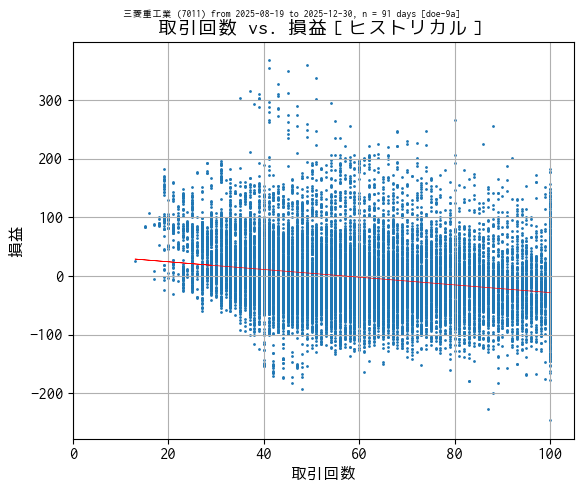

In [23]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(x, y, s=1)
ax.plot(x, pred, c='red',lw=0.5)

ax.grid()
ax.set_xlim(0, 105)
ax.set_xlabel("取引回数")
ax.set_ylabel("損益")
ax.set_title("取引回数 vs. 損益［ヒストリカル］")

plt.tight_layout()
output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_corr_trade_profit_all.png"
)
plt.suptitle(title_scope, fontsize=7)
plt.subplots_adjust(top=0.917)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

In [24]:
# 平均収益の算出
n = len(df_mean.index)
while n > 0:
    # 最下行から順に平均値を算出して、行の内容を置換。
    df_mean.iloc[n - 1] = df_mean[:n].mean()
    n -= 1
print("\ndf_mean: 新しい日付から古い日付と逆順に平均損益を算出")
print(df_mean)

# 最終日の平均収益のランキング
ser_ranking = df_mean.iloc[len(df_mean) - 1].sort_values(ascending=False)
print("最新の平均損益（逆ソート後）")
print(ser_ranking)


df_mean: 新しい日付から古い日付と逆順に平均損益を算出
                  0          1          2          3          4          5    \
2025-08-19  15.000000  15.000000   7.000000 -10.000000  29.000000  14.000000   
2025-08-20  16.000000  17.000000   4.500000  -5.500000  14.500000  13.500000   
2025-08-21   8.333333   6.333333   0.666667  -4.000000  12.666667  10.000000   
2025-08-22  -2.000000  -6.000000 -16.000000  -8.750000  -3.750000  -1.000000   
2025-08-25  -4.400000  -7.800000 -12.000000  -8.800000  -3.400000  -0.800000   
...               ...        ...        ...        ...        ...        ...   
2025-12-24   0.218391  -2.528736  -6.517241  -9.264368 -10.482759  -8.724138   
2025-12-25   0.193182  -2.590909  -6.534091  -9.102273 -10.613636  -8.784091   
2025-12-26  -0.157303  -2.977528  -6.719101  -9.213483 -10.674157  -8.741573   
2025-12-29  -0.233333  -3.322222  -6.755556  -9.222222 -10.744444  -8.900000   
2025-12-30  -0.692308  -3.626374  -6.901099  -9.384615 -10.835165  -8.967033   

      

In [25]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均収益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary["total"] - df_mean.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


In [26]:
# トップランキング
n_top = 5
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_best.columns = list_col
dt_last = df_raw.index[-1]
ser_best_last = df_raw.loc[dt_last][best_conditions]
df_best[dt_last.date()] = ser_best_last

print("---\n[Best Conditions]")
print(df_best)

# HTML 形式で出力
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_best.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_negative.columns = list_col
dt_last = df_raw.index[-1]
ser_negative_last = df_raw.loc[dt_last][negative_conditions]
df_negative[dt_last.date()] = ser_negative_last

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
    PERIOD_MA_1  PERIOD_MA_2       取引回数      平均損益  2025-12-30
81          160          500  58.087912  6.329670       -35.0
15          180          300  84.615385  6.307692       -13.0
16          190          300  93.032967  5.879121        -8.0
99          170          550  54.054945  5.769231       -20.0
82          170          500  57.780220  5.615385       -28.0
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2       取引回数       平均損益  2025-12-30
144          110          700  53.010989  -0.021978        -1.0
128          120          650  53.505495  -0.142857       -14.0
148          150          700  45.923077  -0.164835       -19.0
223           50          950  58.912088  -0.197802        19.0
111          120          600  52.318681  -0.274725       -18.0
..           ...          ...        ...        ...         ...
19            50          350  95.395604  -9.868132       -34.0
23            90          350  87.802198 -10.472527       -22.0
38       

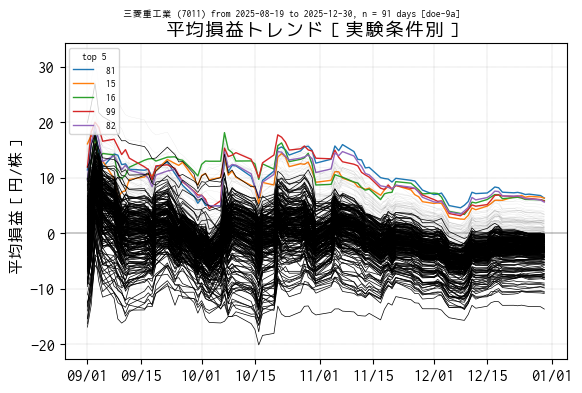

In [27]:
# ---------------------------------------------------------
# 実験条件毎の平均損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_mean[dt_from <= df_mean.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均損益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("平均損益［円/株］")
ax.set_title("平均損益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_mean_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

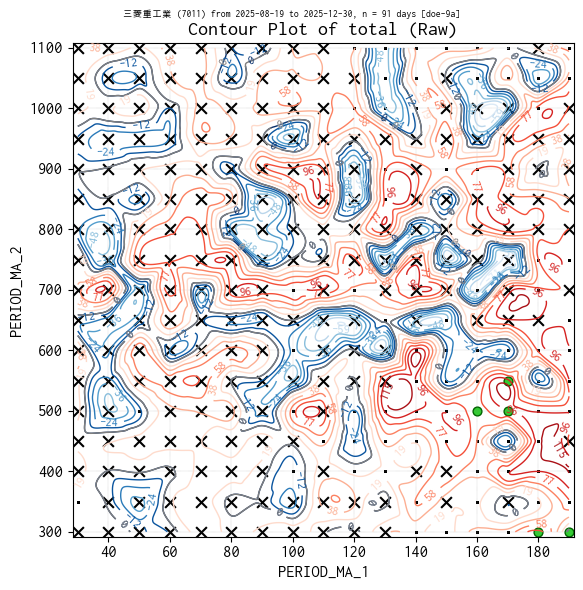

In [28]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# 等高線図
plot_contourmap(ax, Xi, Yi, Zi)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title("Contour Plot of total (Raw)")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_best[col_x],
    df_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
ax.scatter(
    df_negative[col_x],
    df_negative[col_y],
    marker="x",
    color="black",
    s=60,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_raw_contour_{target}.png"
)

plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

In [29]:
df_median = df_raw.copy()

## サマリ統計（メジアン）

### 検算

## ランキング (2)

## 実験条件毎の収益トレンド（メジアン）